In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import pysynphot as S
from scipy.integrate import simps
from matplotlib import pyplot as plt
from astropy.io import fits
from IPython.display import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Look at stored files

In [21]:
# The model params/filenames are stored in a lookup table called catalog.fits
H = fits.open('/grp/hst/cdbs/grid/phoenix/catalog.fits')
H[1].data

FITS_rec([('10000,+0.3,0.0', 'phoenixp03/phoenixp03_10000.fits[g00]'),
          ('10000,+0.3,0.5', 'phoenixp03/phoenixp03_10000.fits[g05]'),
          ('10000,+0.3,1.0', 'phoenixp03/phoenixp03_10000.fits[g10]'), ...,
          ('9800,-4.0,4.5', 'phoenixm40/phoenixm40_9800.fits[g45]'),
          ('9800,-4.0,5.0', 'phoenixm40/phoenixm40_9800.fits[g50]'),
          ('9800,-4.0,5.5', 'phoenixm40/phoenixm40_9800.fits[g55]')],
         dtype=(numpy.record, [('INDEX', 'S20'), ('FILENAME', 'S60')]))

## Check the calculated Teff

In [22]:
# Snippet to calculate Teff
slc = slice(800, -600)
def calc_temp(t, m, g):
    sp = S.Icat('phoenix', t, m, g)
    sp.convert('flam')
    wave = (sp.wave*1E-10)[slc]
    fluxmks = (sp.flux*1E-7*1E4*1E10)[slc]
    teff = int((simps(fluxmks, wave)*1./5.67E-8)**0.25)
    plt.plot(wave, fluxmks, label="{} {}".format(t, teff))
    plt.ylabel('Flux density [W/m2/m]')
    plt.xlabel('Wavelength [m]')
    plt.loglog()
    plt.legend()

<IPython.core.display.Javascript object>


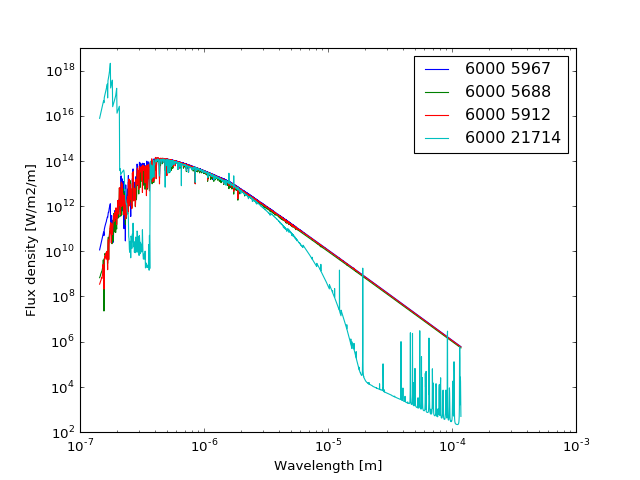

In [23]:
calc_temp(6000, 0, 3.5)

In [24]:
calc_temp(6000, 0, 4)

In [25]:
calc_temp(6000, 0, 4.5)

In [26]:
calc_temp(6000, 0, 5)

## Make sure the code is pulling the right model

In [27]:
def file_check(t, m, g):
    sp = S.Icat('phoenix', t, m, g)
    file = '/grp/hst/cdbs/grid/phoenix/phoenixm00/phoenixm00_{}.fits'.format(int(t))
    hdu = fits.open(file)
    raw_flux = hdu[1].data['g{}'.format(int(g*10))] # erg/cm^2/s/Angstrom
    fig, ax = plt.subplots()
    ax.plot(sp.wave, sp.flux, label='pysynphot')
    ax.plot(sp.wave, raw_flux, label='raw')
    plt.loglog()
    plt.ylim(1E-4, 1E8)
    plt.xlim(1E3, 1E5)
    plt.legend(loc=0)

<IPython.core.display.Javascript object>


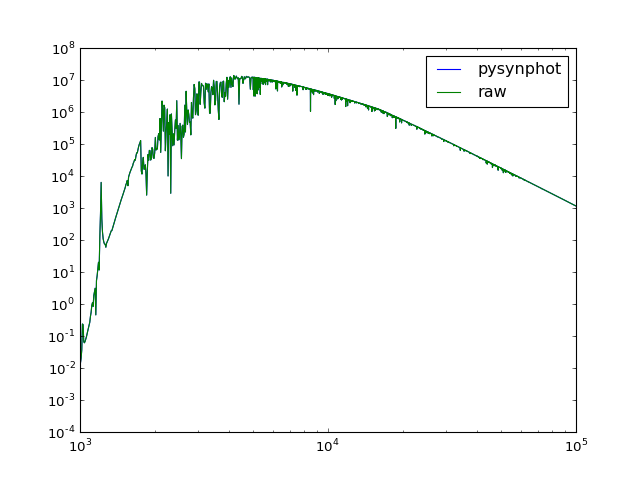

<IPython.core.display.Javascript object>


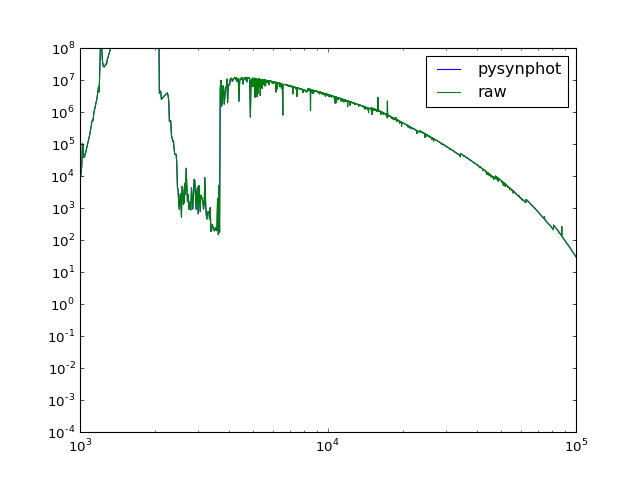

In [28]:
file_check(6000, 0, 3.5)
file_check(6000, 0, 5)

Yes, it it. This means that some of the Phoenix models in `/grp/hst/cdbs/grid/phoenix/` are wrong and the `pysynphot` code works as intended.

## Compare the Icat and raw Phoenix files
This is a comparison between the results of `pysynphot.Icat` and the mu=1 models of the Phoenix ACES grid.

In [29]:
def compare(t, m, g):
    hdu = fits.open('/user/jfilippazzo/Models/ATLAS9/Z-0.0/ATLAS9_{}_{}_p00.fits'.format(int(t), int(g*10)))
    wave = hdu['WAVELENGTH'].data
    flux = hdu['PRIMARY'].data[-1]
    sp = S.Icat('phoenix', t, m, g)
    fig, ax = plt.subplots()
    ax.plot(sp.wave, sp.flux, label='pysynphot')
    ax.plot(wave, flux*3E-13, label='raw')
    plt.loglog()
    plt.ylim(1E-4, 1E8)
    plt.xlim(1E3, 1E5)
    plt.legend(loc=0)

<IPython.core.display.Javascript object>


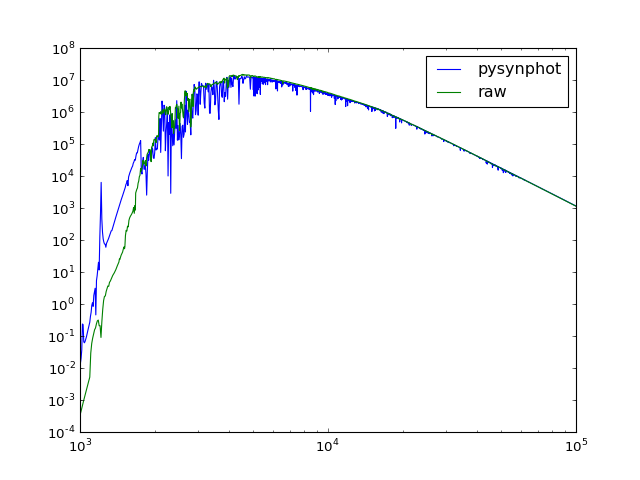

In [30]:
compare(6000, 0, 3.5)

<IPython.core.display.Javascript object>


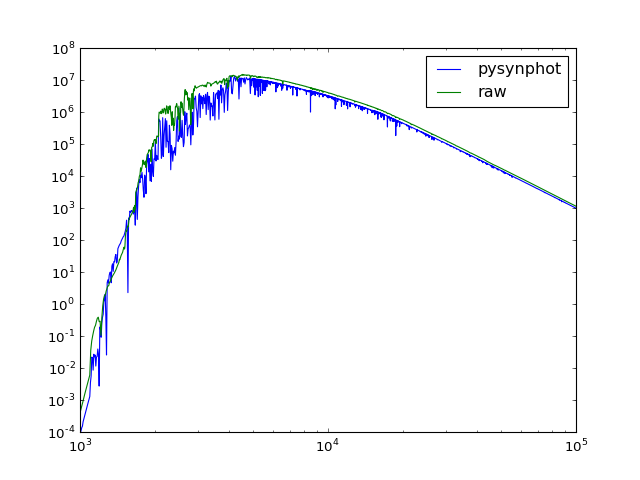

In [31]:
compare(6000, 0, 4)

<IPython.core.display.Javascript object>


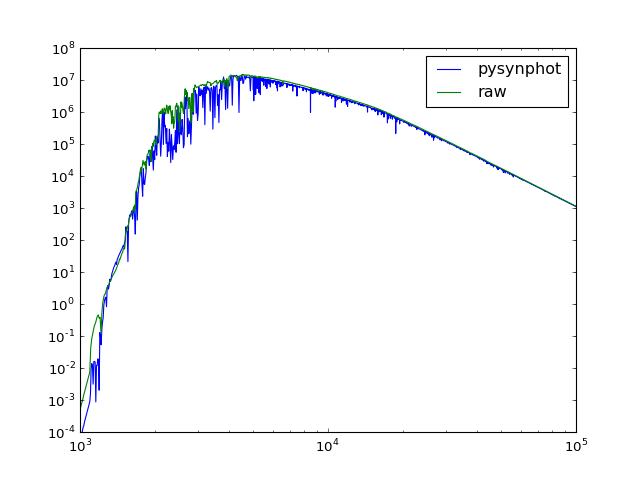

In [32]:
compare(6000, 0, 4.5)

<IPython.core.display.Javascript object>


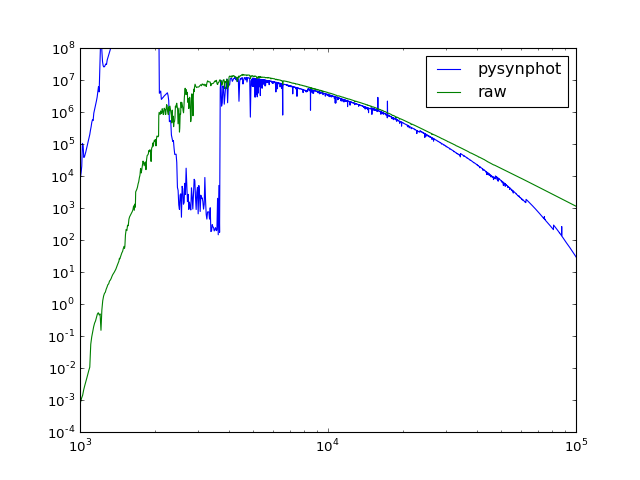

In [33]:
compare(6000, 0, 5)

## See if BT-Settl and NextGen model grids have anomalous spectra at Teff=6000K

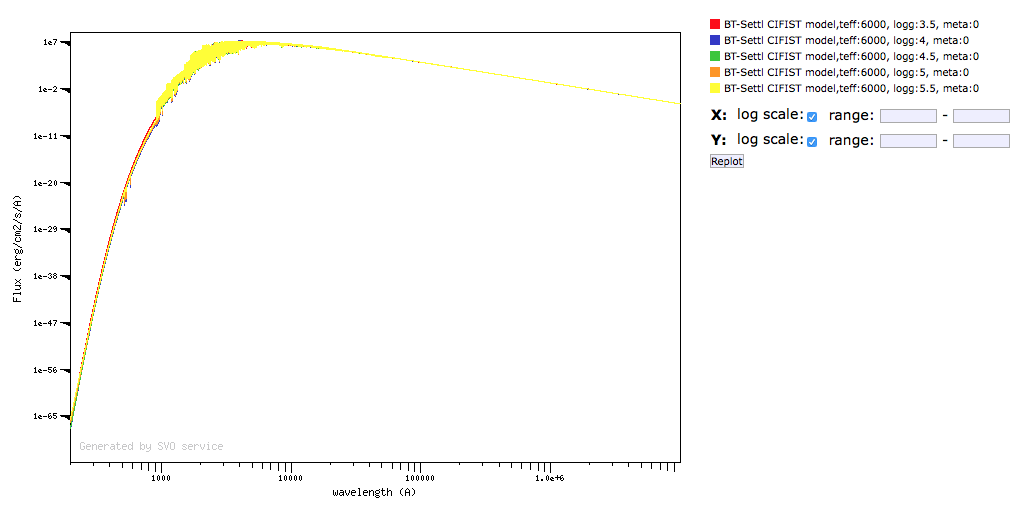

In [38]:
Image('images/fig1.png')

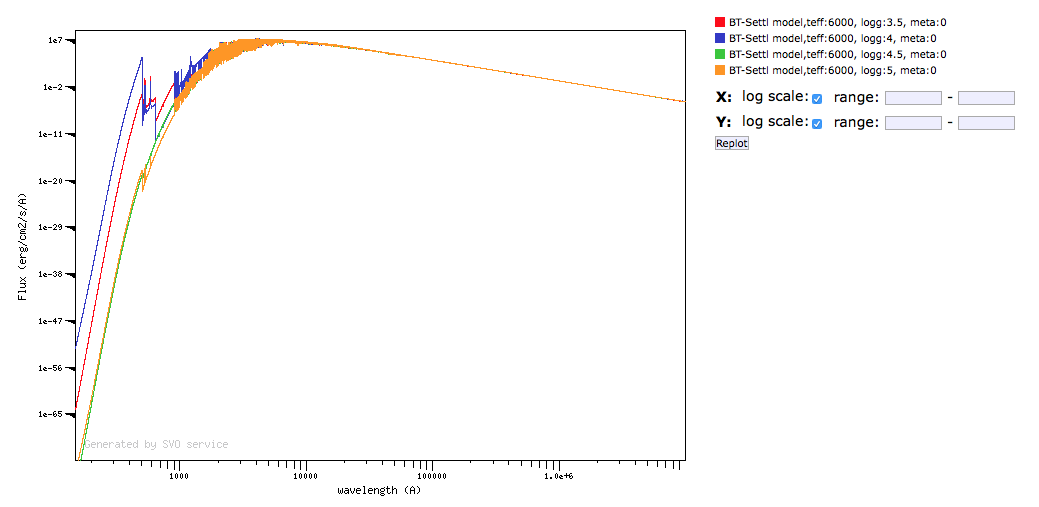

In [39]:
Image('images/fig2.png')

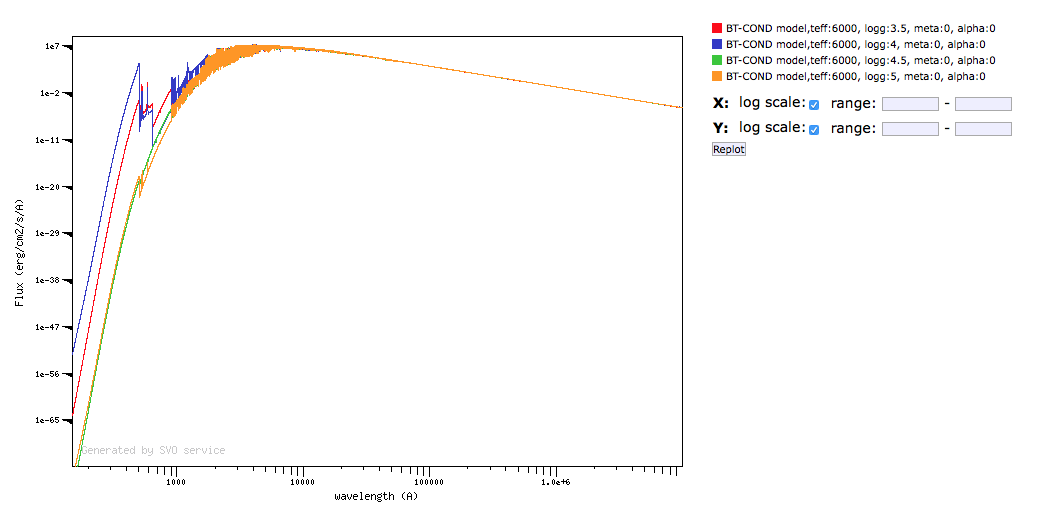

In [40]:
Image('images/fig3.png')

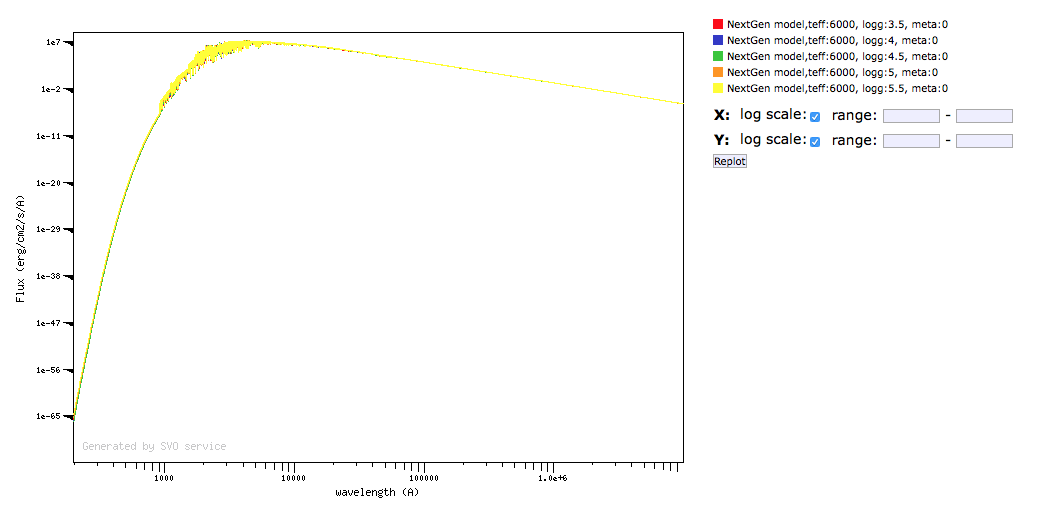

In [41]:
Image('images/fig4.png')

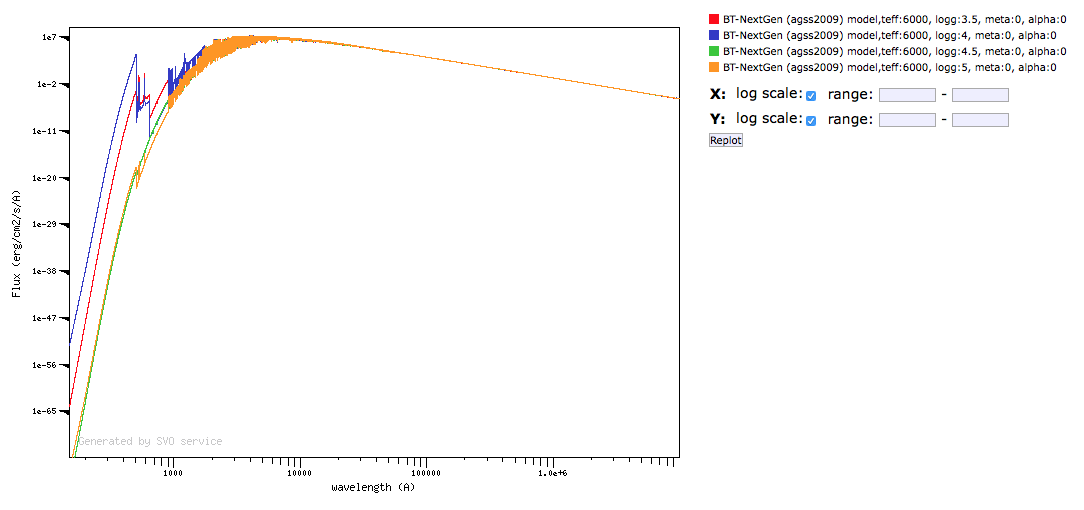

In [42]:
Image('images/fig5.png')

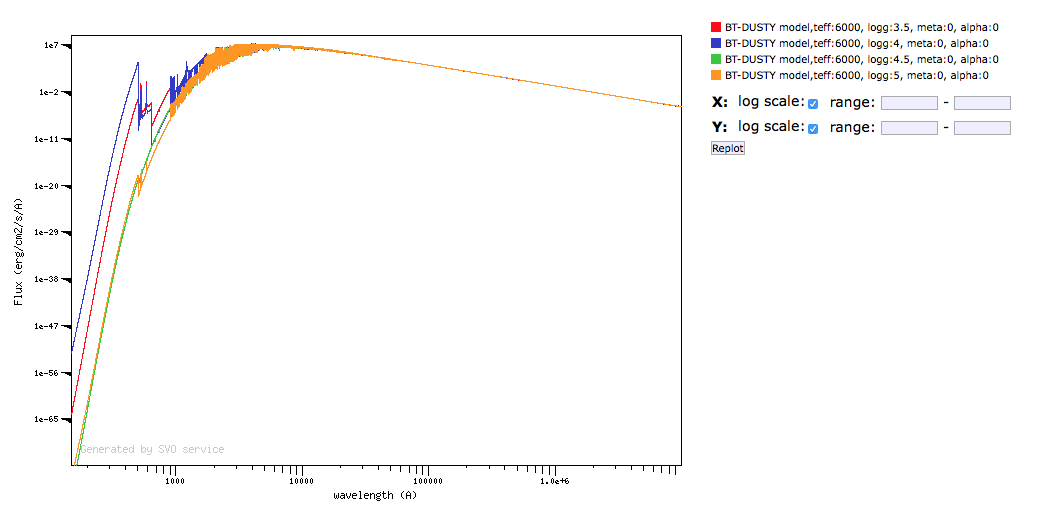

In [43]:
Image('images/fig6.png')

The BT-Settl models look a little wonky short of 0.1um but reasonable otherwise. And certainly none of them looks like the [6000, 0, 5] model from `pysynphot`. 

### It looks like the script used to process the raw Phoenix models into the files stored on ST servers and used by `pysynphot` went a little haywire. `pysynphot` sems to be pulling them out correctly though.